In [1]:
!pip install fastai==2.5.1 -q
!pip install nltk -q
# install autocorrect library
!pip install autocorrect

In [2]:
from fastai.text.all import *
import pandas as pd
from pathlib import Path

## 1. Read Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')
root = "/content/drive/MyDrive/deep_learning_salon/nlp_proj1_disaster_tweets"
os.chdir(root)
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
analysis  data	documentation  models


In [4]:
train_df = pd.read_csv(os.path.join(root, 'data/raw_dataset/train.csv'))
test_df = pd.read_csv(os.path.join(root, 'data/raw_dataset/test.csv'))
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


### 1.1 Data Preprocessing 

**Get a copy of the original training and testing data**

In [5]:
tweets = train_df.copy()
test_tweets = test_df.copy()

1.1.1. Remove Hyperlinks and Hashtags

In [6]:
# library for regular expressions
import re 
def remove_hyper_hash_number(text_in):
    # remove hyperlinks
    text_in = re.sub(r'https?:\/\/.\S+', "", text_in)
    # remove hashtags
    # only removing the hash # sign from the word
    text_in = re.sub(r'#', '', text_in)
    # remove all the numbers
    text_out = re.sub(r'\d+', '', text_in)
    return text_out

1.1.2 Split Attched Words

In [7]:
# Split attached words: Some words are joined together for example – “ForTheWin”. 
# These need to be separated to be able to extract the meaning out of it. 
# After splitting, it will be “For The Win”

def split_attach(text_in):
    #separate the words
    text_out = " ".join([s for s in re.split("([A-Z][a-z]+[^A-Z]*)",text_in) if s])
    return text_out

1.1.3 Convert to Lower

In [8]:
# Convert to lower case: Convert your text to lower case to avoid case sensitivity related issues.
def convert_lower(text_in):
    text_out = text_in.lower()
    return text_out

1.1.4 Slang Lookup

In [9]:
# Slang lookup: There are many slang words which are used nowadays, and they 
# can be found in the text data. So we need to replace them with their meanings. 
# We can use a dictionary of slang words as we did for the contraction replacement, 
# or we can create a file consisting of the slang words.

slang_dict = {}
with open(Path(root)/'data'/'ref_file'/'slang.txt',"r") as file_handle:
    slangs = file_handle.readlines()
    for slang_pair in slangs:
        slang, slang_meaning = slang_pair.strip().split("=")
        slang_dict[slang] = slang_meaning

def replace_slang(text_in):
    text_token = text_in.split(' ')
    #replace the slang word with meaning
    for i,word in enumerate(text_token):
        if word in list(slang_dict.keys()):
            text_token[i] = slang_dict[word]         
    text_out = " ".join(text_token)
    return text_out

1.1.5 Expand contractions

In [10]:
# Expand English language contraction：
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

def expand_contraction(text_in):
    #expand contractions (specific)
    text_ = re.sub(r"won\'t", "will not", text_in)
    text_ = re.sub(r"can\'t", "can not", text_)
    #expand contractions (general)
    text_ = re.sub(r"n\'t", " not", text_)
    text_ = re.sub(r"\'re", " are", text_)
    text_ = re.sub(r"\b\'s", " is", text_)
    text_ = re.sub(r"\'d", " would", text_)
    text_ = re.sub(r"\'ll", " will", text_)
    text_ = re.sub(r"\'t", " not", text_)
    text_ = re.sub(r"\'ve", " have", text_)
    text_out = re.sub(r"\'m", " am", text_)
    return text_out

1.1.6 Remove Punctuations

In [11]:
# Remove Punctuations: Punctuations consists of !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~. 

# for string operations
import string, re  
regex = re.compile('[%s]' % re.escape(string.punctuation))

def remove_punctuations(text_in):
    return regex.sub('', text_in)

1.1.7 Spell Check

In [12]:
# Standardizing and Spell Check: There might be spelling errors in the text or it 
# might not be in the correct format. For example – “drivng” for “driving” or “I 
# misssss this” for “I miss this”. We can correct these by using the autocorrect 
# library for python. There are other libraries available which you can use as well. 

import itertools
from autocorrect import Speller

def spell_check(text_in):
    spell = Speller(lang='en')
    #spell check
    text_out = spell(text_in)
    return text_out

1.1.8 Remove Stop Words

In [13]:
# Remove Stopwords: Stop words are the words which occur frequently in the text but 
# add no significant meaning to it. For this, we will be using the nltk library which 
# consists of modules for pre-processing data. It provides us with a list of stop words. 
# You can create your own stopwords list as well according to the use case

import nltk
#download the stopwords from nltk using
nltk.download('stopwords')
#import stopwords
from nltk.corpus import stopwords
 
#import english stopwords list from nltk
stopwords_eng = stopwords.words('english')

def remove_stop_word(text_in):
    text_tokens = text_in.split()
    text_out_tokens = []
    #remove stopwords
    for word in text_tokens:
        if word not in stopwords_eng:
            text_out_tokens.append(word)
    text_out = " ".join(text_out_tokens)
    return text_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1.1.9 Stemming and Lemmatization

In [14]:
# Stemming is a process of reducing words to their word stem, base or root form 
# (for example, books — book, looked — look). The main two algorithms are Porter 
# stemming algorithm (removes common morphological and inflexional endings from 
# words) and Lancaster stemming algorithm (a more aggressive stemming algorithm). 
# In the “Stemming” sheet of the table some stemmers are described.

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
stemmer = PorterStemmer()

# The aim of lemmatization, like stemming, is to reduce inflectional forms to a 
# common base form. As opposed to stemming, lemmatization does not simply chop 
# off inflections. Instead it uses lexical knowledge bases to get the correct base forms of words.
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()

def stem_lemma(text_in):
    text_tokens = word_tokenize(text_in)
    text_out_tokens = []
    for word in text_tokens:
        stemmed = stemmer.stem(word)
        text_out_tokens.append(lemmatizer.lemmatize(stemmed))
    text_out = " ".join(text_out_tokens)
    return text_out

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


1.1.10 Organize all the preprocessing into a function and apply on text

In [15]:
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


Debug

In [16]:
    text_try = '1300 Our Deeds are the Reason, of this #earthquake May ALLAH Forgave us all!!'
    print('before any preprocessing : ', text_try)
    text_in = remove_hyper_hash_number(text_try)
    print('remove_hyper_and_hash :', text_in)
    text_in = split_attach(text_in)
    print('split_attach :', text_in)
    text_in = convert_lower(text_in)
    print('convert_lower :',text_in)
    text_in = replace_slang(text_in)
    print('replace_slang :', text_in)
    text_in = expand_contraction(text_in)
    print('expand_contraction :',text_in)
    text_in = remove_punctuations(text_in)
    print('remove_punctuations :',text_in)
    text_in = spell_check(text_in)
    print('spell_check :',text_in)
    text_in = remove_stop_word(text_in)
    print('remove_stop_word :', text_in)
    text_out = stem_lemma(text_in)
    print('stem_lemma :',text_in)

before any preprocessing :  1300 Our Deeds are the Reason, of this #earthquake May ALLAH Forgave us all!!
remove_hyper_and_hash :  Our Deeds are the Reason, of this earthquake May ALLAH Forgave us all!!
split_attach :   Our  Deeds are the  Reason, of this earthquake  May  ALLAH  Forgave us all!!
convert_lower :   our  deeds are the  reason, of this earthquake  may  allah  forgave us all!!
replace_slang :   our  deeds are the  reason, of this earthquake  may  allah  forgave us all!!
expand_contraction :   our  deeds are the  reason, of this earthquake  may  allah  forgave us all!!
remove_punctuations :   our  deeds are the  reason of this earthquake  may  allah  forgave us all
spell_check :   our  deeds are the  reason of this earthquake  may  alla  forgive us all
remove_stop_word : deeds reason earthquake may alla forgive us
stem_lemma : deeds reason earthquake may alla forgive us


Organize into one function

In [17]:
def preprocessing_text(text_in):
    text_in = remove_hyper_hash_number(text_in)
    text_in = split_attach(text_in)
    text_in = convert_lower(text_in)
    text_in = replace_slang(text_in)
    text_in = expand_contraction(text_in)
    text_in = remove_punctuations(text_in)
    text_in = spell_check(text_in)
    text_in = remove_stop_word(text_in)
    text_out = stem_lemma(text_in)
    return text_out

**process the training and testing set**

In [18]:
tweets.text = tweets.text.apply(lambda x: preprocessing_text(x))

In [19]:
test_tweets.text = test_tweets.text.apply(lambda x: preprocessing_text(x))

In [20]:
train_df = tweets.copy()
test_df = test_tweets.copy()

**save as processed**

In [21]:
train_df.to_csv(Path(root)/'data'/'ref_file'/'train.csv', index = False)
test_df.to_csv(Path(root)/'data'/'ref_file'/'test.csv', index = False)

## 2. Use Pretrained BERT Model from PyTorch - Preparation

In [22]:
!pip install transformers

### 2.1. Extract the sentences and labels of our training set as numpy ndarrays.

In [23]:
# Get the lists of sentences and their labels.
sentences = train_df.text.values
labels = train_df.target.values

In [24]:
len(sentences)

7613


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [25]:
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


### 2.2. Tokenize Dataset

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [26]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  38


The maximum number of character in a tweet is 280, so we'll set the max sentence length as 96.

In [27]:
set_max_len = 50

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). 

Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [28]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = set_max_len,  # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  deed reason earthquak may alla forgiv u
Token IDs: tensor([  101, 15046,  3114,  3011, 16211,  2243,  2089, 25699,  2005,  5856,
         2615,  1057,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


### 2.3. Sub-Training and Sub-Validation Splits for Training Set 

In [29]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

#-# Create a 4:1 train-validation split.
# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,090 training samples
1,523 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [30]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## 3. Use Pretrained BERT Model from PyTorch - Training

### 3.1. Load the Modified version of the exsiting BERT model

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

The documentation for these can be found under [here](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).


We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 

There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [31]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

The pretrained BERT lower-case model is 440M

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.

In [32]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

### 3.2 Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 3 

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [33]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [34]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### 3.3 Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *[Stas Bekman](https://ca.linkedin.com/in/stasbekman) contributed the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 


**Define some helper function for evaluation and timing**

In [35]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [36]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

**Load GPU**

In [37]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [38]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    191.    Elapsed: 0:00:22.
  Batch    80  of    191.    Elapsed: 0:00:43.
  Batch   120  of    191.    Elapsed: 0:01:05.
  Batch   160  of    191.    Elapsed: 0:01:27.

  Average training loss: 0.51
  Training epcoh took: 0:01:44

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.46
  Validation took: 0:00:09

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    191.    Elapsed: 0:00:22.
  Batch    80  of    191.    Elapsed: 0:00:44.
  Batch   120  of    191.    Elapsed: 0:01:06.
  Batch   160  of    191.    Elapsed: 0:01:28.

  Average training loss: 0.40
  Training epcoh took: 0:01:45

Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.43
  Validation took: 0:00:09

======== Epoch 3 / 3 ========
Training...
  Batch    40  of    191.    Elapsed: 0:00:22.
  Batch    80  of    191.    Elapsed: 0:00:44.
  Batch   120  of    191.    Elapsed: 0:01:06.
  Batch   160  of    191.    Elapsed: 0:01:28.



In [39]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.51,0.46,0.80,0:01:44,0:00:09
2,0.40,0.43,0.82,0:01:45,0:00:09
3,0.32,0.46,0.82,0:01:45,0:00:09


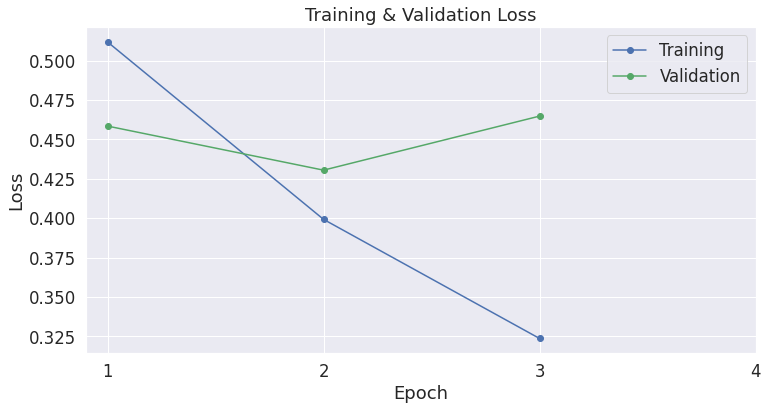

In [40]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## 3.  Use Pretrained BERT Model from PyTorch - Testing

In [41]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,happen terribl car crash
1,2,NaN,NaN,heard earthquak differ citi stay safe everyon
2,3,NaN,NaN,forest fire spot pond gee flee across street can not save
3,9,NaN,NaN,apocalyps light spoken wildfir
4,11,NaN,NaN,typhoon soudelor kill china taiwan


In [42]:
# Report the number of test_sentences.
print('Number of test test_sentences: {:,}\n'.format(test_df.shape[0]))

# Create sentence and label lists
test_sentences = test_df.text.values
test_labels = np.zeros(len(test_sentences))

# Tokenize all of the test_sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in test_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = set_max_len,  # Pad & truncate all test_sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
test_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test test_sentences: 3,263



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [43]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
# predictions , true_labels = [], []
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  # true_labels.append(label_ids)
print('    DONE.')

Predicting labels for 3,263 test sentences...
    DONE.


In [44]:
pred_label = []
for pred in predictions:
  pred_labels_i = np.argmax(pred, axis=1).flatten()
  pred_label = pred_label+ list(pred_labels_i)

In [45]:
result_dict = {}
result_dict['id'] = list(test_df.id)
result_dict['target'] = pred_label

In [46]:
result_df = pd.DataFrame(result_dict)

In [47]:
result_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [48]:
from pathlib import Path

In [49]:
result_df.to_csv(Path(root)/'data'/'Prediction'/'preprocessing_bert.csv', index = False)